## Importing all the Reuqired libraries

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from darts import TimeSeries
import pandas as pd
import nltk
import numpy as np
import spacy
from spacy import displacy
from spacy import tokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import huggingface_hub
import matplotlib.pyplot as plt
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rajenderkapur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Table of Contents
### Time Series Analysis
1) Analysis with the use of just Macro Economic Data
2) Include the sentiment analysis data 
    2.1 Investigate forecasting with all the sentiment analysis techniques
    2.2 Conclude the best sentiment analysis technique
3) In Sentiment Analysis also include financial documents and perform finbert on it too

### Reading the Macro-data and Sentiment Data for Reliance

In [117]:
# This is the excel file to read the macro data
Macrodf = pd.read_excel('Stock-data.xlsx')

# Removing the first unamed column 
Macrodf = Macrodf.drop(columns=['Unnamed: 0'])

# Sentiment Data 
sentiments = pd.read_excel('allarticles.xlsx')
sentiments = sentiments.drop(columns='Unnamed: 0')

#Changing the dtype of the date column to get into correct date-time format
Macrodf.Date = pd.to_datetime(Macrodf.Date)

# Renaming the last two columns to the right name 
#! Put this in the data collection code
renamingcols = {'INR_x':'Gold_Price','INR_y':'USD_Exchange_Rate','INR':'Brent_Oil'}
Macrodf = Macrodf.rename(columns=renamingcols)


## PreProcessing the Text Data and removing outliers from the macroeconomic data

In [134]:
def todatetime(dataframe,datecols=['Date','Date.1','Date.2','Date.3']):
    '''
    Function to convert all the different date columns columns into pandas datetime format
    '''
    for col in datecols:
        dataframe[col] = pd.to_datetime(pd.to_datetime(dataframe[col]).dt.date)
    return dataframe


def cleaning(dataframe,opinioncols=['Politics','Headlines','News_titles','Tweets']):
    '''
    Cleaning function including processing and stopwords removal as well
    '''
    # First just keeping words and removing special characters in this case
    dataframe[opinioncols] = dataframe[opinioncols].replace('[^a-zA-Z]'," ",regex = True)
    # Getting all the stopwords
    all_stopwords = stopwords.words('english')
    # Removing some stopwords which may be important
    all_stopwords.remove('not')
    all_stopwords.remove("wasn't")
    # Lemmatizing the words
    wnl = WordNetLemmatizer()
    # Then removing all the stopwords
    for col in opinioncols:
        processed = []
        for i in range(len(dataframe[col])):
            # Lowering all the sentences before stemming and lemmatosation
            processing = str(dataframe[col][i]).lower()
            processing = nltk.word_tokenize(processing)
            processing = [wnl.lemmatize(word) for word in processing if word not in all_stopwords]
            final = ' '.join(processing)
            processed.append(final)
        # This is to get the right values in the column
        dataframe[col] = processed
    return dataframe


def slicingdf(dataframe):
    '''
    This is the slicing function to split dataframe into differnt dataframes from 4 different sources
    '''
    # The US political data sentiments from reddit
    df1 = dataframe.iloc[:,0:2]

    # The Indian Headlines from reddit
    df2 = dataframe.iloc[:,2:4]
    df2.columns = ['Date','Headlines']

    # The Indian News titiles from financial times
    df3 = dataframe.iloc[:,4:6]
    df3.columns = ['Date','News_Titles']

    # The Tweets about reliance from Twitter
    df4 = dataframe.iloc[:,6:8]
    df4.columns = ['Date','Tweets']

    return [df1,df2,df3,df4]


# Combining all the Sentiments from different sources together and making a new dataframe with all sources from the specific date 
def combineSentiments(dataframe):
    '''
    This function is to combine all the dataframes with differnt sources of sentiments together 
    with their dates so you can get combination of all dates together to make sentiment scores on specific dates
    This returns a cleaned dataset with all the sentiments combined on a common date
    df -> df 
    '''
    sentimentlist = []
    list_of_dataframes = slicingdf(dataframe)

    # This groups all sentiments with the right dates and returns list of dataframes with right 
    for dataframe in list_of_dataframes:
        dategrouping = pd.DataFrame(dataframe.groupby(['Date'])[list(dataframe.columns)[1]],columns=[dataframe.columns])
        sentimentlist.append(dategrouping)

    # This here is to combine all the dataframes together as groupby fn causes some inidices problems
    g = []
    for dataframes in sentimentlist:
        dataframes.to_clipboard(index=False)
        dataframes=pd.read_clipboard(sep='\t')
        g.append(dataframes)
        
    
    all = pd.merge(pd.merge(g[0],g[1],how='outer',on='Date'),pd.merge(g[2],g[3],how='outer',on='Date'),how='outer',on='Date')
    all = all.fillna('')
    cols = ['Politics', 'Headlines', 'News_Titles','Tweets']
    all['Combined'] = all[cols].apply(lambda row: '.'.join(row.values.astype(str)), axis=1)
    final = all[['Date','Combined']]
    final = cleaning(final,opinioncols=['Combined'])
    return final


def sentimentAnalysers(dataframe):
    '''
    Different Sentiment Anlysers used 
    1) Vader 
    2) Nltk Sentiment Analyser
    3) Finbert BERT based on bert pre-trained on financial documents used this for analysis --> Same thing as flair
    4) Combination of Twitter BERT pretrained and Financial for News articles 
    Different ones done here to see which one gives the best capture of what is happening with the market
    '''
    dataframe1 = dataframe.copy()
    dataframe2 = dataframe.copy()
    dataframe3 = dataframe.copy()
    # 1) Vader Sentiment Analyser

    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    sid_obj = SentimentIntensityAnalyzer()
    '''polarity_scores method of SentimentIntensityAnalyzer object gives a sentiment dictionary,which contains pos, neg, neu,compound scores.'''
    dataframe1['Negative'] = dataframe1.apply(lambda x: sid_obj.polarity_scores(x['Combined'])['neg'],axis=1)
    dataframe1['Positive'] = dataframe1.apply(lambda x: sid_obj.polarity_scores(x['Combined'])['pos'],axis=1)
    dataframe1['Neutral'] = dataframe1.apply(lambda x: sid_obj.polarity_scores(x['Combined'])['neu'],axis=1)
    dataframe1['Max_Sentiment'] = dataframe1[['Negative','Positive','Neutral']].idxmax(axis=1)
    
    # 2) Ntlk Sentiment Analyser
    from nltk.sentiment import SentimentIntensityAnalyzer
    import operator
    sia = SentimentIntensityAnalyzer()
    dataframe2["sentiment_score"] = dataframe2['Combined'].apply(lambda x: sia.polarity_scores(x)["compound"])
    dataframe2["sentiment"] = np.select([dataframe2["sentiment_score"] < 0, dataframe2["sentiment_score"] == 0, 
                            dataframe2["sentiment_score"] > 0],['neg', 'neu', 'pos'])

    # 3) BERT Based Finbert pretrained model
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    from transformers import BertTokenizer,BertForSequenceClassification
    from transformers import pipeline

    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",num_labels=3)
    nlp = pipeline('sentiment-analysis',model =finbert,tokenizer = tokenizer )

    dataframe3['Label'] = dataframe3.apply(lambda x: nlp(x['Combined'])[0]['label'],axis=1)
    dataframe3['Score'] = dataframe3.apply(lambda x: nlp(x['Combined'])[0]['score'],axis=1)
    dataframe3.Date = pd.to_datetime(dataframe3.Date)
    
    return [dataframe1,dataframe2,dataframe3]


def featureEng(macrodf):
    '''
    Feature Engineering with Macrodataset to create categorical column which says if close price increased or decreased from yesterday
    Hopefully better for the model as a covariate
    '''
    macrodf['Diff'] = macrodf.Close.diff()   
    up_or_down = []
    for i in range(len(macrodf['Diff'])):
        if macrodf['Diff'][i] > 0:
            up_or_down.append('Increase')
        elif macrodf['Diff'][i] < 0:
            up_or_down.append('Decrease')
        else:
            up_or_down.append('Same')
    macrodf['Change'] = up_or_down

    return macrodf

def removeOutliers(dataframe):
    '''
    In this function we remove outliers, but instead of removing whole rows the outliers are replaced with nan values which are then filled
    This is so that there is min loss of data
    '''
    q_low = dataframe['Gold_Price'].quantile(0.01)
    q_hi  = dataframe['Gold_Price'].quantile(0.99)
    mask = (dataframe['Gold_Price'] > q_hi) & (dataframe['Gold_Price'] < q_low)
    dataframe.loc[mask]['Gold_Price'] = np.nan

    q_low1 = dataframe['Brent_Oil'].quantile(0.01)
    q_hi1  = dataframe['Brent_Oil'].quantile(0.99)
    mask = (dataframe['Brent_Oil'] > q_hi) & (dataframe['Brent_Oil'] < q_low)
    dataframe.loc[mask,'Brent_Oil']['Brent_Oil'] = np.nan

    return dataframe

    
def mergingMacroSentiment(macrodf,listsentimentdf):
    '''
    Merging the Macroeconomic and Sentiment dataframe which is done after the outliers are removed from the macroeconomic dataset and
    feature engineering has been performed, so here a list is outputted to get the list of merged dataframes with macro and sentiment df
    with different sentiment analysers
    '''
    macrodf = removeOutliers(macrodf)
    mergedDataframes = []
    for sentimentdf in listsentimentdf:
        macrodf = todatetime(macrodf,datecols=['Date'])
        sentimentdf = todatetime(sentimentdf,datecols=['Date'])
        mergeddf = pd.merge(macrodf,sentimentdf,how='inner',on=['Date'])
        mergeddf = featureEng(mergeddf)
        mergedDataframes.append(mergeddf)
    return mergedDataframes
    

def all(macrodf,dataframe):
    ''''
    Complete function with all preprocessing and merging has been performed
    '''
    dataframe = todatetime(dataframe)
    dataframe = combineSentiments(dataframe)
    listDataframes = sentimentAnalysers(dataframe)
    mergedDfs = mergingMacroSentiment(macrodf,listDataframes)
    return mergedDfs,listDataframes    

In [119]:
merged,listdfs = all(Macrodf,sentiments)

/var/folders/7p/66tsh0jd16n29z6nlxd264n80000gn/T/ipykernel_93565/4111517227.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[opinioncols] = dataframe[opinioncols].replace('[^a-zA-Z]'," ",regex = True)
/var/folders/7p/66tsh0jd16n29z6nlxd264n80000gn/T/ipykernel_93565/4111517227.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col] = processed


### Investigating the missing dates and filling the missing values as well as checking if any seasonality in any Macro Variables

2022-09-21 12:16:10 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 12:16:10 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 12:16:10 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 12:16:10 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 12:16:11 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

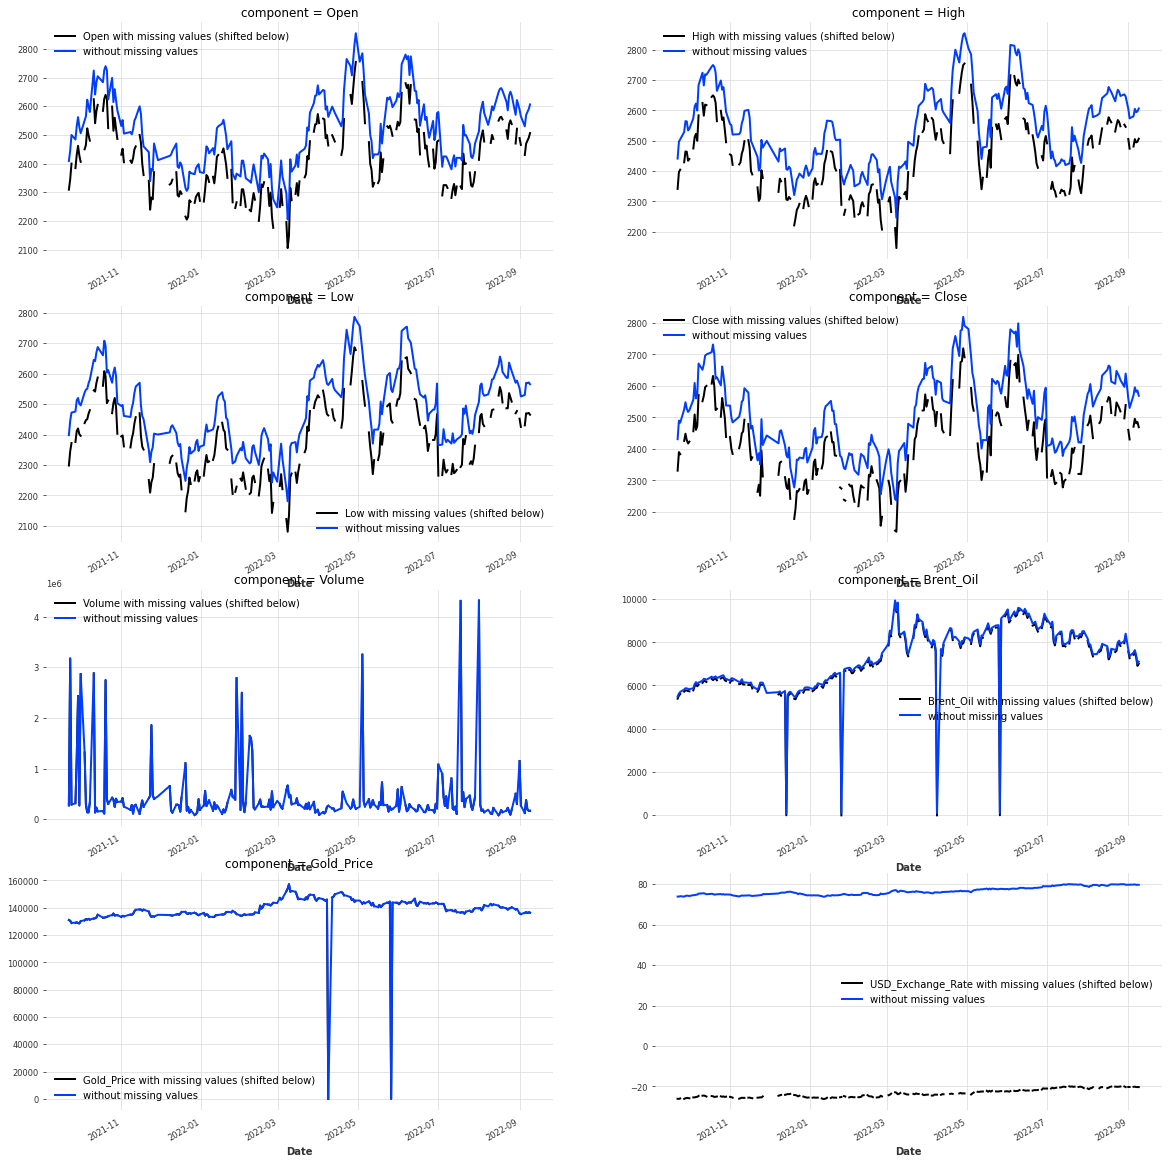

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 15 in this Brent_Oil.
There is seasonality of order 18 in this Brent_Oil.
There is seasonality of order 22 in this Brent_Oil.
There is seasonality of order 10 in this Gold_Price.
There is seasonality of order 16 in this Gold_Price.
There is seasonality of order 20 in this Gold_Price.


In [138]:
# Making into Timeseries object as required by Darts
Macrodf = removeOutliers(Macrodf)
Macro = TimeSeries.from_dataframe(df = Macrodf,time_col='Date',fill_missing_dates=True,freq='D')
from darts.utils.missing_values import fill_missing_values
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
ax = ax.ravel()
i = 0 
for col in list(Macro.columns):
    (Macro[col] - 100).plot(label=f"{col} with missing values (shifted below)",ax = ax[i])
    fill_missing_values(Macro[col]).plot(label="without missing values",ax = ax[i])
    ax[i].legend()
    i+=1

plt.show()


# Filling Missing Values 
Macro = fill_missing_values(Macro)

# Checking Seasonality
from darts.utils.statistics import plot_acf, check_seasonality
for col in Macro.columns:
    for m in range(2, 25):
        is_seasonal, period = check_seasonality(Macro[col], m=m, alpha=0.05)
        if is_seasonal:
            print("There is seasonality of order {} in this {}.".format(period,col))

#### Training LTSM Model on Just Macroeconomic Data

/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/darts/timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-09-20 16:28:41 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-20 16:28:41 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-20 16:28:41 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-20 16:28:41 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
2022-09-20 16:28:41

Training: 0it [00:00, ?it/s]

2022-09-20 16:29:06 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


Predicting: 8it [00:00, ?it/s]

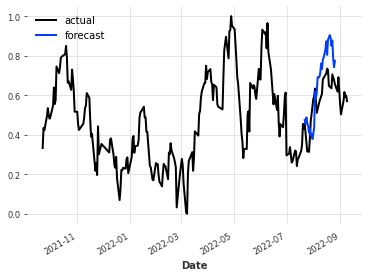

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

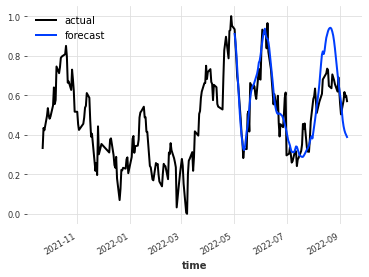

MAPE (using covariates) = 14.95%


In [5]:
covcols =['Open', 'High', 'Low', 'Volume', 'Brent_Oil', 'Gold_Price', 'USD_Exchange_Rate']
# Data Preprocessing to scale the data before splitting
macro_scale = Scaler()
Macro = macro_scale.fit_transform(Macro)
# The target variable is first split into last 50 periods 
taget_train,target_val = Macro['Close'][:-50],Macro['Close'][-50:]
covariate_train,covariate_val = Macro[covcols][:-50],Macro[covcols][-50:]
model_cov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=50,
    output_chunk_length=24,
    n_epochs=300,
    random_state=0,
)
model_cov.fit(
    series=taget_train,
    past_covariates=covariate_train,
    verbose=True,
)
pred_cov = model_cov.predict(n=36, series=taget_train, past_covariates=Macro[covcols])
Macro['Close'].plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()
plt.show()

backtest_cov = model_cov.historical_forecasts(
    Macro['Close'],
    past_covariates=Macro[covcols],
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
    verbose=False,
)

Macro['Close'].plot(label="actual")
backtest_cov.plot(label="forecast")
plt.legend()
plt.show()
print("MAPE (using covariates) = {:.2f}%".format(mape(Macro['Close'], backtest_cov)))

In [27]:
MacroSentimentdf = pd.merge(Macrodf,final[['Date','Label','Score']],how='inner',on='Date')
MacroSentimentdf['Diff'] = MacroSentimentdf.Close.diff()   
up_or_down = []
for i in range(len(MacroSentimentdf['Diff'])):
    if MacroSentimentdf['Diff'][i] > 0:
        up_or_down.append('Increase')
    elif MacroSentimentdf['Diff'][i] < 0:
        up_or_down.append('Decrease')
    else:
        up_or_down.append('Same')
MacroSentimentdf['Change'] = up_or_down
MacroSentimentdf['Max_Sentiment'] = MacroSentimentdf[['Negative','Positive']].idxmax(axis=1)

In [31]:
final1['Negative'] = final1.apply(lambda x: sid_obj.polarity_scores(x['Combined'])['neg'],axis=1)
final1['Positive'] = final1.apply(lambda x: sid_obj.polarity_scores(x['Combined'])['pos'],axis=1)
final1['Neutral'] = final1.apply(lambda x: sid_obj.polarity_scores(x['Combined'])['neu'],axis=1)
final1.Date = pd.to_datetime(final.Date)
# final1 = final1[['Date','Negative','Positive','Neutral']]
MacroSentimentdf = pd.merge(Macrodf,final1[['Date','Negative','Positive','Neutral']],how='inner',on='Date')
MacroSentimentdf['Diff'] = MacroSentimentdf.Close.diff()   
up_or_down = []
for i in range(len(MacroSentimentdf['Diff'])):
    if MacroSentimentdf['Diff'][i] > 0:
        up_or_down.append('Increase')
    elif MacroSentimentdf['Diff'][i] < 0:
        up_or_down.append('Decrease')
    else:
        up_or_down.append('Same')
MacroSentimentdf['Change'] = up_or_down


NameError: name 'final1' is not defined

In [310]:
pd.DataFrame(MacroSentimentdf.groupby('Change')['Max_Sentiment'].value_counts())

Max_Sentiment
Change   Max_Sentiment               
Decrease Negative                  77
         Positive                  40
Increase Negative                  75
         Positive                  39
Same     Positive                   1

In [386]:
from nltk.sentiment import SentimentIntensityAnalyzer
import operator
sia = SentimentIntensityAnalyzer()
final["sentiment_score"] = final['Combined'].apply(lambda x: sia.polarity_scores(x)["compound"])
final["sentiment"] = np.select([final["sentiment_score"] < 0, final["sentiment_score"] == 0, final["sentiment_score"] > 0],
                           ['neg', 'neu', 'pos'])
final.Date = pd.to_datetime(final.Date)
MacroSentimentdf1 = pd.merge(Macrodf,final[['Date','sentiment_score','sentiment']],how='inner',on='Date')
MacroSentimentdf1['Diff'] = MacroSentimentdf1.Close.diff()   
up_or_down = []
for i in range(len(MacroSentimentdf1['Diff'])):
    if MacroSentimentdf1['Diff'][i] > 0:
        up_or_down.append('Increase')
    elif MacroSentimentdf1['Diff'][i] < 0:
        up_or_down.append('Decrease')
    else:
        up_or_down.append('Same')
MacroSentimentdf1['Change'] = up_or_down

/var/folders/7p/66tsh0jd16n29z6nlxd264n80000gn/T/ipykernel_21044/3270916416.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["sentiment_score"] = final['Combined'].apply(lambda x: sia.polarity_scores(x)["compound"])
/var/folders/7p/66tsh0jd16n29z6nlxd264n80000gn/T/ipykernel_21044/3270916416.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["sentiment"] = np.select([final["sentiment_score"] < 0, final["sentiment_score"] == 0, final["sentiment_score"] > 0],
/var/folders/7p/66tsh0jd16n29z6nlxd

In [387]:
MacroSentimentdf1=MacroSentimentdf1.fillna(0)
MacroSentimentdf1 = pd.get_dummies(MacroSentimentdf1, columns=['sentiment'])
MacroSentimentdf1.Change=MacroSentimentdf1.Change.astype('category').cat.codes

In [389]:
# Making into Timeseries object as required by Darts
Macro = TimeSeries.from_dataframe(df = MacroSentimentdf1,time_col='Date',fill_missing_dates=True,freq='D')


In [390]:
# Filling Missing Values 
Macro = fill_missing_values(Macro)
# Checking Seasonality
from darts.utils.statistics import plot_acf, check_seasonality
for col in Macro.columns:
    for m in range(2, 25):
        is_seasonal, period = check_seasonality(Macro[col], m=m, alpha=0.05)
        if is_seasonal:
            print("There is seasonality of order {} in this {}.".format(period,col))

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 15 in this Brent_Oil.
There is seasonality of order 18 in this Brent_Oil.
There is seasonality of order 22 in this Brent_Oil.
There is seasonality of order 10 in this Gold_Price.
There is seasonality of order 16 in this Gold_Price.
There is seasonality of order 20 in this Gold_Price.
There is seasonality of order 7 in this sentiment_score.
There is seasonality of order 14 in this sentiment_score.
There is seasonality of order 16 in this sentiment_score.
There is seasonality of order 21 in this sentiment_score.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 6 in this Change.
There is seasonality of order 11 in this Change.
There is seasonality of order 14 in this Change.
There is seasonality of order 23 in this Change.
There is seasonality of order 11 in this sentiment_neg.
There is sea

/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/darts/timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-09-20 13:27:50 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-20 13:27:50 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-20 13:27:50 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-20 13:27:50 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
2022-09-20 13:27:50

Training: 0it [00:00, ?it/s]

2022-09-20 13:28:47 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=600` reached.


Predicting: 8it [00:00, ?it/s]

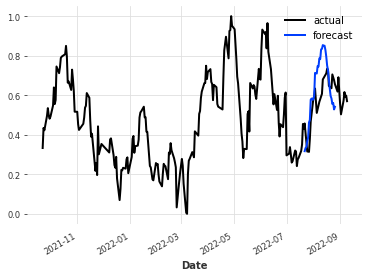

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

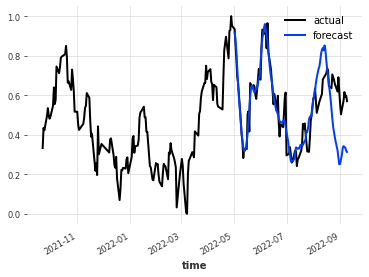

MAPE (using covariates) = 15.78%


In [393]:
covcols =['Open', 'High', 'Low', 'Volume', 'Brent_Oil', 'Gold_Price',
       'USD_Exchange_Rate', 'sentiment_score', 'Diff', 'Change',
       'sentiment_neg', 'sentiment_neu', 'sentiment_pos']
# Data Preprocessing to scale the data before splitting
macro_scale = Scaler()
Macro = macro_scale.fit_transform(Macro)
# The target variable is first split into last 50 periods 
taget_train,target_val = Macro['Close'][:-50],Macro['Close'][-50:]
# taget_train1,target_val1 = Sentiment['Negative'][:-50],Sentiment['Negative'][-50:]
covariate_train,covariate_val = Macro[covcols][:-50],Macro[covcols][-50:]
# covariate_train1,covariate_val1 = Sentiment[covcols1][:-50],Sentiment[covcols1][-50:]
model_cov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=50,
    output_chunk_length=24,
    n_epochs=600,
    random_state=0,
)
model_cov.fit(
    series=taget_train,
    past_covariates=covariate_train,
    verbose=True,
)
pred_cov = model_cov.predict(n=36, series=taget_train, past_covariates=Macro[covcols])
Macro['Close'].plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()
plt.show()

backtest_cov = model_cov.historical_forecasts(
    Macro['Close'],
    past_covariates=Macro[covcols],
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
    verbose=False,
)

Macro['Close'].plot(label="actual")
backtest_cov.plot(label="forecast")
plt.legend()
plt.show()
print("MAPE (using covariates) = {:.2f}%".format(mape(Macro['Close'], backtest_cov)))

/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/darts/timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-09-20 13:28:51 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-20 13:28:51 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-20 13:28:51 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-20 13:28:51 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
2022-09-20 13:28:51

Training: 0it [00:00, ?it/s]

2022-09-20 13:29:47 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=600` reached.


Predicting: 8it [00:00, ?it/s]

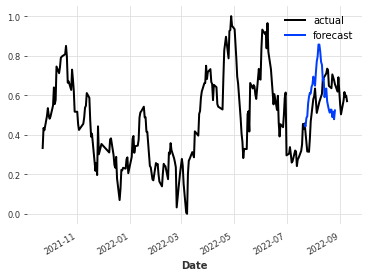

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

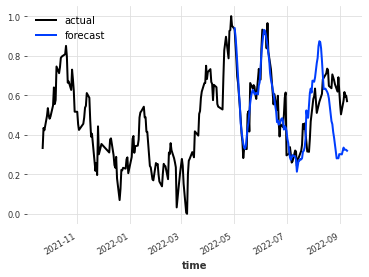

MAPE (using covariates) = 19.36%


In [394]:
# totransform = ['Open', 'High','Close', 'Low', 'Volume', 'Brent_Oil','Gold_Price', 'USD_Exchange_Rate']
covcols =['Open', 'High', 'Low', 'Volume', 'Brent_Oil', 'Gold_Price',
       'USD_Exchange_Rate', 'sentiment_score', 'Diff', 'Change',
       'sentiment_neg', 'sentiment_neu', 'sentiment_pos']
# Data Preprocessing to scale the data before splitting
macro_scale = Scaler()
Macro = macro_scale.fit_transform(Macro)
# The target variable is first split into last 50 periods 
taget_train,target_val = Macro['Close'][:-50],Macro['Close'][-50:]
# taget_train1,target_val1 = Sentiment['Negative'][:-50],Sentiment['Negative'][-50:]
covariate_train,covariate_val = Macro[covcols][:-50],Macro[covcols][-50:]
# covariate_train1,covariate_val1 = Sentiment[covcols1][:-50],Sentiment[covcols1][-50:]
model_cov = BlockRNNModel(
    model="GRU",
    input_chunk_length=50,
    output_chunk_length=24,
    n_epochs=600,
    random_state=0,
)
model_cov.fit(
    series=taget_train,
    past_covariates=covariate_train,
    verbose=True,
)
pred_cov = model_cov.predict(n=36, series=taget_train, past_covariates=Macro[covcols])
Macro['Close'].plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()
plt.show()

backtest_cov = model_cov.historical_forecasts(
    Macro['Close'],
    past_covariates=Macro[covcols],
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
    verbose=False,
)

Macro['Close'].plot(label="actual")
backtest_cov.plot(label="forecast")
plt.legend()
plt.show()
print("MAPE (using covariates) = {:.2f}%".format(mape(Macro['Close'], backtest_cov)))

/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/darts/timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-09-20 13:29:52 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-20 13:29:52 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-20 13:29:52 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-20 13:29:52 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
2022-09-20 13:29:52

Training: 0it [00:00, ?it/s]

2022-09-20 13:30:27 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=600` reached.


Predicting: 8it [00:00, ?it/s]

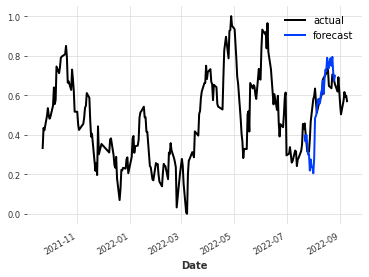

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

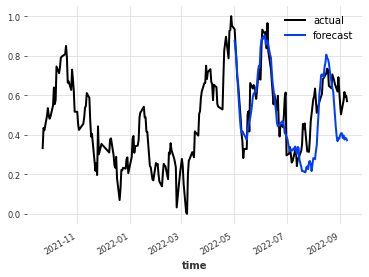

MAPE (using covariates) = 18.09%


In [395]:
covcols =['Open', 'High', 'Low', 'Volume', 'Brent_Oil', 'Gold_Price',
       'USD_Exchange_Rate', 'sentiment_score', 'Diff', 'Change',
       'sentiment_neg', 'sentiment_neu', 'sentiment_pos']# totransform = ['Open', 'High','Close', 'Low', 'Volume', 'Brent_Oil','Gold_Price', 'USD_Exchange_Rate']
# Data Preprocessing to scale the data before splitting
macro_scale = Scaler()
Macro = macro_scale.fit_transform(Macro)
# The target variable is first split into last 50 periods 
taget_train,target_val = Macro['Close'][:-50],Macro['Close'][-50:]
# taget_train1,target_val1 = Sentiment['Negative'][:-50],Sentiment['Negative'][-50:]
covariate_train,covariate_val = Macro[covcols][:-50],Macro[covcols][-50:]
# covariate_train1,covariate_val1 = Sentiment[covcols1][:-50],Sentiment[covcols1][-50:]
model_cov = BlockRNNModel(
    model="RNN",
    input_chunk_length=50,
    output_chunk_length=24,
    n_epochs=600,
    random_state=0,
)
model_cov.fit(
    series=taget_train,
    past_covariates=covariate_train,
    verbose=True,
)
pred_cov = model_cov.predict(n=36, series=taget_train, past_covariates=Macro[covcols])
Macro['Close'].plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()
plt.show()

backtest_cov = model_cov.historical_forecasts(
    Macro['Close'],
    past_covariates=Macro[covcols],
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
    verbose=False,
)

Macro['Close'].plot(label="actual")
backtest_cov.plot(label="forecast")
plt.legend()
plt.show()
print("MAPE (using covariates) = {:.2f}%".format(mape(Macro['Close'], backtest_cov)))

In [396]:
from flair.models import TextClassifier
from flair.data import Sentence

classifier = TextClassifier.load('en-sentiment')
sentence = Sentence('The food was great!')
classifier.predict(sentence)

# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)

2022-09-20 13:51:48,550 loading file /Users/rajenderkapur/.flair/models/sentiment-en-mix-distillbert.pt


ModuleNotFoundError: No module named 'transformers.modeling_distilbert'

In [275]:
# Making into Timeseries object as required by Darts
Macro = TimeSeries.from_dataframe(df = MacroSentimentdf,time_col='Date',fill_missing_dates=True,freq='D')
# Sentiment = TimeSeries.from_dataframe(df=final1,time_col='Date',fill_missing_dates=True,freq='D')
# from darts.utils.missing_values import fill_missing_values
# fig, ax = plt.subplots(3,1, figsize=(20, 20))
# ax = ax.ravel()
# i = 0 
# for col in list(Sentiment.columns):
#     (Sentiment[col] - 0.5).plot(label=f"{col} with missing values (shifted below)",ax = ax[i])
#     fill_missing_values(Sentiment[col]).plot(label="without missing values",ax = ax[i])
#     ax[i].legend()
#     i+=1

# plt.show()


In [276]:
# Filling Missing Values 
Macro = fill_missing_values(Macro)
# Checking Seasonality
from darts.utils.statistics import plot_acf, check_seasonality
for col in Macro.columns:
    for m in range(2, 25):
        is_seasonal, period = check_seasonality(Macro[col], m=m, alpha=0.05)
        if is_seasonal:
            print("There is seasonality of order {} in this {}.".format(period,col))

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 15 in this Brent_Oil.
There is seasonality of order 18 in this Brent_Oil.
There is seasonality of order 22 in this Brent_Oil.
There is seasonality of order 10 in this Gold_Price.
There is seasonality of order 16 in this Gold_Price.
There is seasonality of order 20 in this Gold_Price.
There is seasonality of order 8 in this Negative.
There is seasonality of order 10 in this Negative.
There is seasonality of order 22 in this Negative.
There is seasonality of order 8 in this Positive.
There is seasonality of order 14 in this Positive.
There is seasonality of order 16 in this Positive.
There is seasonality of order 21 in this Positive.
There is seasonality of order 23 in this Positive.
There is seasonality of order 6 in this Neutral.
There is seasonality of order 8 in this Neutral.
There is seasonality of order 10 in this Neutral.
There is seasonality of order 12 i

/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/darts/timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-09-14 18:44:01 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-14 18:44:01 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-14 18:44:01 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-14 18:44:01 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
2022-09-14 18:44:01

Training: 0it [00:00, ?it/s]

2022-09-14 18:44:57 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=600` reached.


Predicting: 8it [00:00, ?it/s]

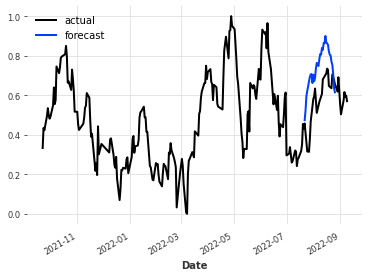

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

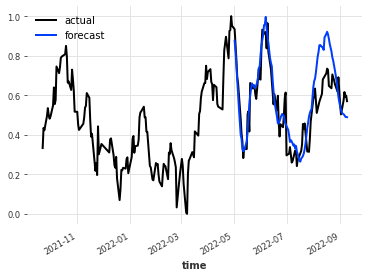

MAPE (using covariates) = 16.13%


In [278]:
covcols =['Open', 'High', 'Low', 'Volume', 'Brent_Oil','Gold_Price', 'USD_Exchange_Rate', 'Negative', 'Positive', 'Neutral']
# Data Preprocessing to scale the data before splitting
macro_scale = Scaler()
Macro = macro_scale.fit_transform(Macro)
# The target variable is first split into last 50 periods 
taget_train,target_val = Macro['Close'][:-50],Macro['Close'][-50:]
# taget_train1,target_val1 = Sentiment['Negative'][:-50],Sentiment['Negative'][-50:]
covariate_train,covariate_val = Macro[covcols][:-50],Macro[covcols][-50:]
# covariate_train1,covariate_val1 = Sentiment[covcols1][:-50],Sentiment[covcols1][-50:]
model_cov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=50,
    output_chunk_length=24,
    n_epochs=600,
    random_state=0,
)
model_cov.fit(
    series=taget_train,
    past_covariates=covariate_train,
    verbose=True,
)
pred_cov = model_cov.predict(n=36, series=taget_train, past_covariates=Macro[covcols])
Macro['Close'].plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()
plt.show()

backtest_cov = model_cov.historical_forecasts(
    Macro['Close'],
    past_covariates=Macro[covcols],
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
    verbose=False,
)

Macro['Close'].plot(label="actual")
backtest_cov.plot(label="forecast")
plt.legend()
plt.show()
print("MAPE (using covariates) = {:.2f}%".format(mape(Macro['Close'], backtest_cov)))

/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/darts/timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-09-16 17:14:40 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-16 17:14:40 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-16 17:14:40 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-16 17:14:40 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
2022-09-16 17:14:40

Training: 0it [00:00, ?it/s]

2022-09-16 17:15:33 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=600` reached.


Predicting: 8it [00:00, ?it/s]

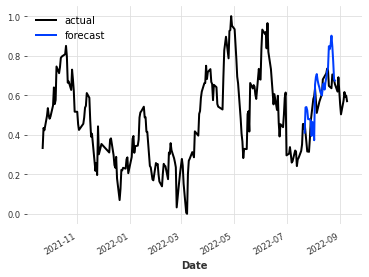

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

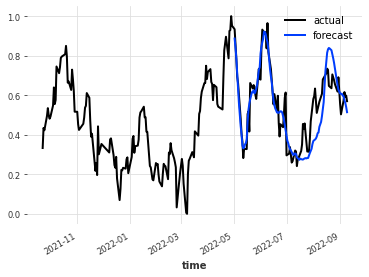

MAPE (using covariates) = 12.86%


In [280]:
covcols =['Open', 'High', 'Low', 'Volume', 'Brent_Oil','Gold_Price', 'USD_Exchange_Rate', 'Negative', 'Positive', 'Neutral']
# totransform = ['Open', 'High','Close', 'Low', 'Volume', 'Brent_Oil','Gold_Price', 'USD_Exchange_Rate']
# Data Preprocessing to scale the data before splitting
macro_scale = Scaler()
Macro = macro_scale.fit_transform(Macro)
# The target variable is first split into last 50 periods 
taget_train,target_val = Macro['Close'][:-50],Macro['Close'][-50:]
# taget_train1,target_val1 = Sentiment['Negative'][:-50],Sentiment['Negative'][-50:]
covariate_train,covariate_val = Macro[covcols][:-50],Macro[covcols][-50:]
# covariate_train1,covariate_val1 = Sentiment[covcols1][:-50],Sentiment[covcols1][-50:]
model_cov = BlockRNNModel(
    model="GRU",
    input_chunk_length=50,
    output_chunk_length=24,
    n_epochs=600,
    random_state=0,
)
model_cov.fit(
    series=taget_train,
    past_covariatexs=covariate_train,
    verbose=True,
)
pred_cov = model_cov.predict(n=36, series=taget_train, past_covariates=Macro[covcols])
Macro['Close'].plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()
plt.show()

backtest_cov = model_cov.historical_forecasts(
    Macro['Close'],
    past_covariates=Macro[covcols],
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
    verbose=False,
)

Macro['Close'].plot(label="actual")
backtest_cov.plot(label="forecast")
plt.legend()
plt.show()
print("MAPE (using covariates) = {:.2f}%".format(mape(Macro['Close'], backtest_cov)))

/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/darts/timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-09-16 20:15:51 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-16 20:15:51 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-16 20:15:51 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-16 20:15:51 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
2022-09-16 20:15:52

Training: 0it [00:00, ?it/s]

2022-09-16 20:16:22 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=600` reached.


Predicting: 8it [00:00, ?it/s]

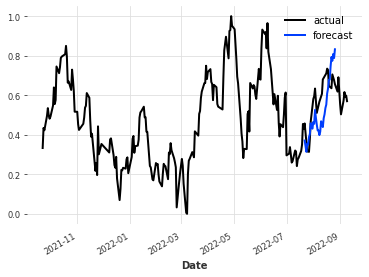

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

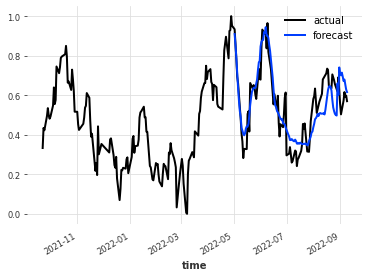

MAPE (using covariates) = 14.86%


In [284]:
covcols =['Open', 'High', 'Low', 'Volume', 'Brent_Oil','Gold_Price', 'USD_Exchange_Rate', 'Negative', 'Positive', 'Neutral']
# totransform = ['Open', 'High','Close', 'Low', 'Volume', 'Brent_Oil','Gold_Price', 'USD_Exchange_Rate']
# Data Preprocessing to scale the data before splitting
macro_scale = Scaler()
Macro = macro_scale.fit_transform(Macro)
# The target variable is first split into last 50 periods 
taget_train,target_val = Macro['Close'][:-50],Macro['Close'][-50:]
# taget_train1,target_val1 = Sentiment['Negative'][:-50],Sentiment['Negative'][-50:]
covariate_train,covariate_val = Macro[covcols][:-50],Macro[covcols][-50:]
# covariate_train1,covariate_val1 = Sentiment[covcols1][:-50],Sentiment[covcols1][-50:]
model_cov = BlockRNNModel(
    model="RNN",
    input_chunk_length=50,
    output_chunk_length=24,
    n_epochs=600,
    random_state=0,
)
model_cov.fit(
    series=taget_train,
    past_covariates=covariate_train,
    verbose=True,
)
pred_cov = model_cov.predict(n=36, series=taget_train, past_covariates=Macro[covcols])
Macro['Close'].plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()
plt.show()

backtest_cov = model_cov.historical_forecasts(
    Macro['Close'],
    past_covariates=Macro[covcols],
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
    verbose=False,
)

Macro['Close'].plot(label="actual")
backtest_cov.plot(label="forecast")
plt.legend()
plt.show()
print("MAPE (using covariates) = {:.2f}%".format(mape(Macro['Close'], backtest_cov)))